In [4]:
import torch
import numpy as np
import pandas as pd
import os
from pathlib import Path
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

# Load the data

In [5]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [6]:
df = pd.read_csv(path/'train.csv')
df_test = pd.read_csv(path/'test.csv')

In [4]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Wrangling

Handle missing values, categorical values, etc.

In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<AxesSubplot:>

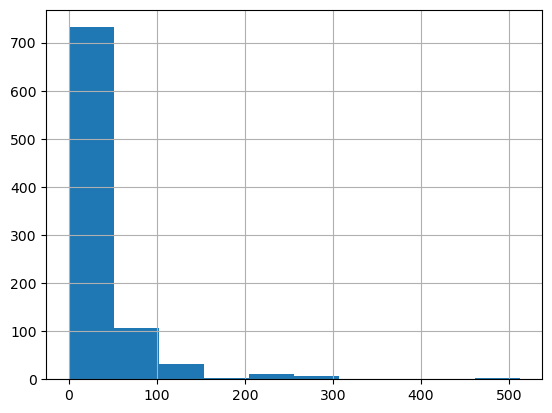

In [6]:
df.Fare.hist()

Fare is a monetary value, best handled using log and then normalized.

In [7]:
df.describe(include=object)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


Sex and Embarked are categoricals with only 2 and 3 unique values. 

In [8]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Handle missing values using the modes of the columns.

In [9]:
modes = df.mode().iloc[0]

In [10]:
df = df.fillna(modes)

<AxesSubplot:>

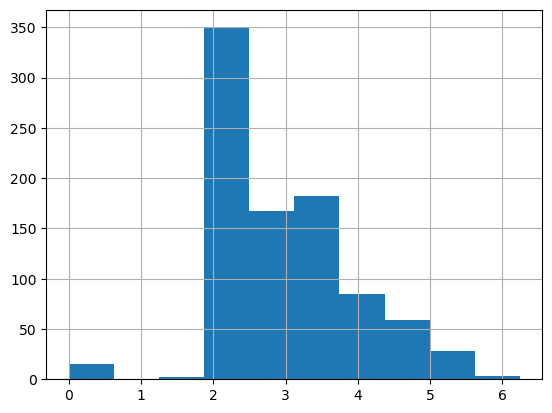

In [11]:
df.Fare.apply(np.log1p).hist()

In [12]:
df.Fare = df.Fare.apply(np.log1p)

In [13]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,2.110213,B96 B98,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.280593,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.188856,B96 B98,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.990834,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.202765,B96 B98,S


In [14]:
cats = ['Sex', 'Pclass', 'Embarked']
df = pd.get_dummies(df, columns=cats)

In [15]:
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
df = df.drop(columns=drop_cols)

In [16]:
# normalize
maxes = df.max()
df = df.div(maxes)

In [17]:
# variable must be defined on train set:
#   modes
#   maxes

def preprocess(df):
    cats = ['Sex', 'Pclass', 'Embarked']
    drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    
    df.Fare = df.Fare.apply(np.log1p)
    
    df = df.fillna(modes)
    
    df = pd.get_dummies(df, columns=cats)
    
    df = (df.drop(columns=drop_cols)
            .div(maxes)
         )
    
    
    return df

In [18]:
comp = df.copy()

In [19]:
df = pd.read_csv(path/'train.csv')
df_test = pd.read_csv(path/'test.csv')

In [20]:
df = preprocess(df)

(df == comp).sum()

Survived      891
Age           891
SibSp         891
Parch         891
Fare          891
Sex_female    891
Sex_male      891
Pclass_1      891
Pclass_2      891
Pclass_3      891
Embarked_C    891
Embarked_Q    891
Embarked_S    891
dtype: int64

train/valid split, and into tensors

In [22]:
from fastai.data.transforms import RandomSplitter
from torch import tensor

# see docs at https://docs.fast.ai/data.transforms.html
train_idx, valid_idx = RandomSplitter(valid_pct=0.2, seed=42)(df)

X_train, y_train = df.iloc[train_idx].drop(columns=['Survived']), df.iloc[train_idx]['Survived']
X_valid, y_valid = df.iloc[valid_idx].drop(columns=['Survived']), df.iloc[valid_idx]['Survived']

X_train = tensor(X_train.values, dtype=torch.float)
X_valid = tensor(X_valid.values, dtype=torch.float)
y_train = tensor(y_train.values, dtype=torch.float)
y_valid = tensor(y_valid.values, dtype=torch.float)

# Create linear learner

Ok let's remember what we're even doing here. For a linear learner, we're going to need a set of randomly initialized weights equal in size to the length of the input. We're going to need a constant bias term (either a ones col, or just an extra param). We're going to need need a loss function, calculate gradients according to that loss, and a way of updating weights based on the gradients. Loop over epochs, print out loss and print out validation accuracy. Let's give it a whirl.

(After doing all that, THEN I'll go back and see whether I missed anything.)

In [23]:
X_train.shape[1]

12

In [24]:
weights = torch.randn(X_train.shape[1])
bias = torch.randn(1)
weights, bias

(tensor([ 0.8738, -0.1948,  1.1477, -0.6449,  1.3456,  0.0802, -1.3830, -1.1722,  0.3663,  1.5820,  0.6060, -0.4627]),
 tensor([0.3514]))

In [26]:
def init_params():
    weights = torch.randn(X_train.shape[1]).requires_grad_()
    bias = torch.randn(1).requires_grad_()
    return weights, bias

In [27]:
weights, bias = init_params()
weights, bias

(tensor([-0.7849, -0.8169,  1.3036, -1.8624, -1.0653, -0.0830, -1.2250, -0.0515, -0.5433,  1.7597, -1.4369, -0.9020], requires_grad=True),
 tensor([-1.9090], requires_grad=True))

for loss, we'll use mean absolute error. this is called the L1 loss. we can define this ourselves, or use the torch.nn.L1Loss function
```loss = nn.L1Loss()```

In [28]:
def mean_abs_error(preds, target):
    return torch.abs(target-preds).mean()

loss_fn = mean_abs_error

# import torch.nn as nn
# loss_func = nn.L1Loss()

so to compute the forward preds, we need to multiple all the inputs by the weights, plus the bias, and sum across rows. let's try this...

In [29]:
preds = X_train@weights + bias
preds = torch.sigmoid(preds)

In [31]:
loss_fn(preds, y_train)

tensor(0.3860, grad_fn=<MeanBackward0>)

In [32]:
loss = loss_fn(preds, y_train)

In [33]:
loss.backward()
weights.grad, bias.grad

(tensor([ 0.0029,  0.0001, -0.0002,  0.0021, -0.0024,  0.0090, -0.0001,  0.0006,  0.0062,  0.0027,  0.0002,  0.0037]),
 tensor([0.0066]))

In [34]:
lr = 1e-5

In [35]:
params = [weights, bias]
for p in params:
    p.data -= p.grad * lr
    p.grad.zero_()

In [36]:
# how do we get the accuracy? 
preds_valid = X_valid@weights + bias
preds_valid = torch.sigmoid(preds_valid)

In [57]:
def forward(X, weights, biases):
    preds = X@weights + biases
    preds = torch.sigmoid(preds)
    return preds

In [86]:
def acc_fn(preds, target):
    acc = (target.bool() == (preds>0.5)).float().mean()
    return acc

acc = acc_fn(preds_valid, y_valid)

Ok I think I have all the pieces - let's see if we can run this multiple times and converge.

In [97]:
def train_model(epochs=20, lr=60):
    weights, biases = init_params()
    
    for n in range(epochs):
        preds = forward(X_train, weights, biases)
        loss = loss_fn(preds, y_train)
        loss.backward()
        for p in [weights, biases]:
            p.data -= p.grad * lr
            p.grad.zero_()
            
        with torch.no_grad():
            preds_valid = forward(X_valid, weights, biases)
            acc = acc_fn(preds_valid, y_valid)
        
        print(f'Epoch: {n}. Loss: {loss:.4f}. Valid acc: {acc:.4f}')

In [98]:
train_model()

Epoch: 0. Loss: 0.6008. Valid acc: 0.7921
Epoch: 1. Loss: 0.3191. Valid acc: 0.6404
Epoch: 2. Loss: 0.3454. Valid acc: 0.8202
Epoch: 3. Loss: 0.2327. Valid acc: 0.7921
Epoch: 4. Loss: 0.2208. Valid acc: 0.8034
Epoch: 5. Loss: 0.2093. Valid acc: 0.8371
Epoch: 6. Loss: 0.2055. Valid acc: 0.8258
Epoch: 7. Loss: 0.2045. Valid acc: 0.8258
Epoch: 8. Loss: 0.2036. Valid acc: 0.8258
Epoch: 9. Loss: 0.2029. Valid acc: 0.8258
Epoch: 10. Loss: 0.2023. Valid acc: 0.8258
Epoch: 11. Loss: 0.2017. Valid acc: 0.8258
Epoch: 12. Loss: 0.2012. Valid acc: 0.8258
Epoch: 13. Loss: 0.2008. Valid acc: 0.8258
Epoch: 14. Loss: 0.2004. Valid acc: 0.8258
Epoch: 15. Loss: 0.2001. Valid acc: 0.8258
Epoch: 16. Loss: 0.1997. Valid acc: 0.8258
Epoch: 17. Loss: 0.1995. Valid acc: 0.8258
Epoch: 18. Loss: 0.1992. Valid acc: 0.8258
Epoch: 19. Loss: 0.1989. Valid acc: 0.8258


Lessons learned: 
- value initialization really matters. initial learning rate of 1e-5 had me worried that the code wasn't working at all. learning rate of 50 ended up working best.
- variable scoping. jesus. related to initial learning rate problem. 

# Create 2-layer neural network

Alright so now we want to do two layers with a non-linear activation between. let's figure out how to structure this with code. not much is going to need to change...

In [108]:
n_hidden = 10
w1 = torch.randn(X_train.shape[1], n_hidden).requires_grad_()
w2 = torch.randn(n_hidden).requires_grad_()
weights = [w1, w2]

In [190]:
import torch.nn as nn
import torch.nn.functional as F
loss_fn = nn.L1Loss()

def init_params():
    n_hidden = 10
    w1 = torch.randn(X_train.shape[1], n_hidden).requires_grad_()
    w2 = torch.randn(n_hidden).requires_grad_()
    weights = [w1, w2]
    biases = [torch.randn(1)[0].requires_grad_(), torch.randn(1)[0].requires_grad_()]
    return weights, biases

def forward(X, params):
    weights, biases = params
    preds = X@weights[0] + biases[0]
    preds = F.relu(preds)
    preds = preds@weights[1] + biases[1]
    preds = torch.sigmoid(preds)
    return preds

# no change
def acc_fn(preds, target):
    acc = (target.bool() == (preds>0.5)).float().mean()
    return acc

def train_model(epochs=20, lr=10):
    params = init_params()
    weights, biases = params
    
    for n in range(epochs):
        preds = forward(X_train, params)
        loss = loss_fn(preds, y_train)
        loss.backward()
        for p in weights+biases:
            p.data -= p.grad * lr
            p.grad.zero_()
            
        with torch.no_grad():
            preds_valid = forward(X_valid, params)
            acc = acc_fn(preds_valid, y_valid)
        
        print(f'Epoch: {n}. Loss: {loss:.4f}. Valid acc: {acc:.4f}')

In [197]:
train_model()

Epoch: 0. Loss: 0.6109. Valid acc: 0.4101
Epoch: 1. Loss: 0.5584. Valid acc: 0.7584
Epoch: 2. Loss: 0.3520. Valid acc: 0.8202
Epoch: 3. Loss: 0.2465. Valid acc: 0.8258
Epoch: 4. Loss: 0.2173. Valid acc: 0.8202
Epoch: 5. Loss: 0.2007. Valid acc: 0.8202
Epoch: 6. Loss: 0.1971. Valid acc: 0.8258
Epoch: 7. Loss: 0.1960. Valid acc: 0.8258
Epoch: 8. Loss: 0.1952. Valid acc: 0.8258
Epoch: 9. Loss: 0.1946. Valid acc: 0.8258
Epoch: 10. Loss: 0.1940. Valid acc: 0.8258
Epoch: 11. Loss: 0.1936. Valid acc: 0.8258
Epoch: 12. Loss: 0.1933. Valid acc: 0.8258
Epoch: 13. Loss: 0.1931. Valid acc: 0.8258
Epoch: 14. Loss: 0.1929. Valid acc: 0.8258
Epoch: 15. Loss: 0.1928. Valid acc: 0.8258
Epoch: 16. Loss: 0.1926. Valid acc: 0.8258
Epoch: 17. Loss: 0.1925. Valid acc: 0.8258
Epoch: 18. Loss: 0.1924. Valid acc: 0.8258
Epoch: 19. Loss: 0.1923. Valid acc: 0.8258


# Create 3-layer neural network

let's add a hidden layer...

gotta say, this one really sealed the deal as far as understanding what's going on with layers and parameter updates. 

In [206]:
import torch.nn.functional as F
loss_fn = F.l1_loss

def init_params():
    n_hidden = 10
    w1 = torch.randn(X_train.shape[1], n_hidden).requires_grad_()
    w2 = torch.randn(n_hidden, n_hidden).requires_grad_()
    w3 = torch.randn(n_hidden, 1).requires_grad_()
    weights = [w1, w2, w3]
    biases = [torch.randn(1)[0].requires_grad_() for _ in range(len(weights))]
    return weights, biases

def forward(X, params):
    weights, biases = params
    n = len(weights)
    
    preds = X@weights[0] + biases[0]
    preds = F.relu(preds)
    for i in range(1, n):
        preds = preds@weights[i] + biases[i]
        if i < n-1:
            preds = F.relu(preds)
        else: 
            preds = torch.sigmoid(preds)
    return preds

# no change
def acc_fn(preds, target):
    acc = (target.bool() == (preds>0.5)).float().mean()
    return acc

def train_model(epochs=20, lr=10):
    params = init_params()
    weights, biases = params
    
    for n in range(epochs):
        preds = forward(X_train, params)
        loss = loss_fn(preds, y_train[:,None])
        loss.backward()
        for p in weights+biases:
            p.data -= p.grad * lr
            p.grad.zero_()
            
        with torch.no_grad():
            preds_valid = forward(X_valid, params)
            acc = acc_fn(preds_valid, y_valid[:,None])
        
        print(f'Epoch: {n}. Loss: {loss:.4f}. Valid acc: {acc:.4f}')

In [214]:
train_model()

Epoch: 0. Loss: 0.3856. Valid acc: 0.7584
Epoch: 1. Loss: 0.2782. Valid acc: 0.7753
Epoch: 2. Loss: 0.2186. Valid acc: 0.6910
Epoch: 3. Loss: 0.3193. Valid acc: 0.7360
Epoch: 4. Loss: 0.2739. Valid acc: 0.7079
Epoch: 5. Loss: 0.2927. Valid acc: 0.7921
Epoch: 6. Loss: 0.2129. Valid acc: 0.7921
Epoch: 7. Loss: 0.2126. Valid acc: 0.7978
Epoch: 8. Loss: 0.2113. Valid acc: 0.8034
Epoch: 9. Loss: 0.2056. Valid acc: 0.8090
Epoch: 10. Loss: 0.2032. Valid acc: 0.8146
Epoch: 11. Loss: 0.1988. Valid acc: 0.8202
Epoch: 12. Loss: 0.1943. Valid acc: 0.8202
Epoch: 13. Loss: 0.1936. Valid acc: 0.8202
Epoch: 14. Loss: 0.1932. Valid acc: 0.8315
Epoch: 15. Loss: 0.1929. Valid acc: 0.8371
Epoch: 16. Loss: 0.1931. Valid acc: 0.8371
Epoch: 17. Loss: 0.1927. Valid acc: 0.8371
Epoch: 18. Loss: 0.1924. Valid acc: 0.8315
Epoch: 19. Loss: 0.1913. Valid acc: 0.8258


# Using a Framework

Here we'll use fastai and PyTorch to simplify many of those steps above.

In [9]:
from fastai.tabular.all import *

set_seed(42)

df = pd.read_csv(path/'train.csv')
df_test = pd.read_csv(path/'test.csv')

splits = RandomSplitter(seed=42)(df)

In [14]:
# variable must be defined on train set:
#   modes
#   maxes

def preprocess(df):
    df.Fare = df.Fare.fillna(0)
    df['LogFare'] = df.Fare.apply(np.log1p)
    
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['Deck'] = (df.Cabin.str[0]
                    .map(dict(A='ABC',
                              B='ABC',
                              C='ABC',
                              D='DE',
                              E='DE',
                              F='FG',
                              G='FG'))
                 )
    df['Title'] = (df.Name
                     .str.split(', ', expand=True)[1]
                     .str.split('.', expand=True)[0]
                     .map(dict(Mr='Mr',
                               Miss='Miss',
                               Mrs='Mrs',
                               Master='Master'))
                  )
    
    # no longer need this, as will be handled by dataloader
#     df = df.fillna(modes)
    
#     cats = ['Sex', 'Pclass', 'Embarked']
#     drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    
#     df = pd.get_dummies(df, columns=cats)
    
#     df = (df.drop(columns=drop_cols)
#             .div(maxes)
#          )
    
    
    return df

In [15]:
df = preprocess(df)
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Family',
       'Alone', 'Deck', 'Title', 'LogFare'],
      dtype='object')

In [16]:
# see https://docs.fast.ai/tabular.core.html#tabularpandas
dls = TabularPandas(df,
                    procs=[Categorify, FillMissing, Normalize], 
                    cat_names=['Sex', 'Pclass', 'Embarked', 'Deck', 'Title'], 
                    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Family', 'Alone'],
                    y_names='Survived',
                    y_block=CategoryBlock(),
                    splits=splits,
                    do_setup=True,
                    device=None,
                    inplace=False,
                    reduce_memory=True).dataloaders(path='.')

In [17]:
learn = tabular_learner(dls,
                        metrics=accuracy,
                        layers=[10,10])

SuggestedLRs(slide=0.0831763744354248, valley=0.015848932787775993)

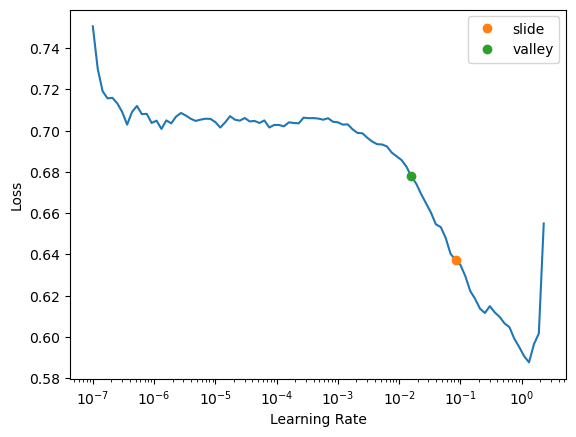

In [18]:
learn.lr_find(suggest_funcs=(slide, valley))

In [19]:
learn.fit(16, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.601420,0.646064,0.595506,00:00
1,0.525531,0.494071,0.775281,00:00
2,0.477161,0.434220,0.792135,00:00
3,0.450097,0.427103,0.814607,00:00
4,0.438997,0.412734,0.842697,00:00
5,0.426286,0.421427,0.803371,00:00
6,0.416050,0.439325,0.837079,00:00
7,0.410603,0.415310,0.786517,00:00
8,0.404997,0.424563,0.825843,00:00
9,0.399146,0.444472,0.837079,00:00


In [23]:
df_test = preprocess(df_test)
dl_test = learn.dls.test_dl(df_test)

preds, _ = learn.get_preds(dl=dl_test)
df_test['Survived'] = (preds[:,1]>0.5).int()

submission = df_test[['PassengerId', 'Survived']]
submission.to_csv('submission.csv', index=False)

In [28]:
!head submission.csv

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,1
900,1
